In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
os.environ['CUDA_VISIBLE_DEVICES']='1'
    
import pandas as pd
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.optim as optim
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the tensors

In [3]:
data = torch.load('ADNI_full_no_nan')

In [4]:
print(f"There are {data['data'].shape[0]} visits with a total of {data['data'].shape[1]*data['data'].shape[2]*data['data'].shape[3]} dimentions")

There are 10047 visits with a total of 614400 dimentions


In [5]:
template_data_path = "/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/subjects/sub-ADNI002S0295/ses-M00/deeplearning_prepare_data/image_based/t1_linear/sub-ADNI002S0295_ses-M00_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt"
template_data = torch.load(template_data_path)
#template_data = template_data[:,::2,::2,::2]

In [6]:
template_data = template_data[:,4:164:2,8:200:2,8:168:2]
template_data.shape

torch.Size([1, 80, 96, 80])

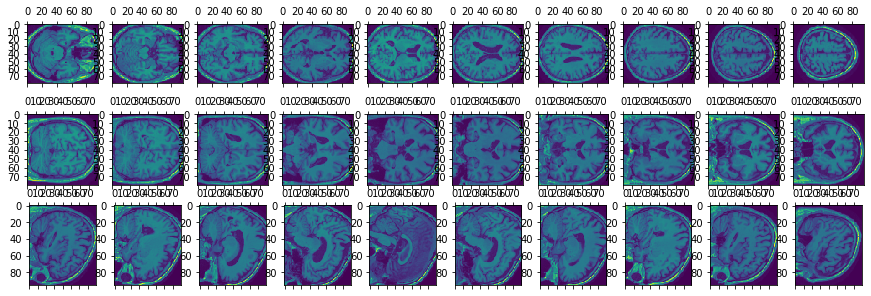

In [9]:
fig, axes = plt.subplots(3,10, figsize=(15,5))


for i in range(10):
    axes[0][i].matshow(template_data[0][:,:,20 + 5*i])
    axes[1][i].matshow(template_data[0][:,20 + 5*i])
    axes[2][i].matshow(template_data[0][20 + 5*i])

#plt.matshow(template_data[0][:,:,40])
plt.show()

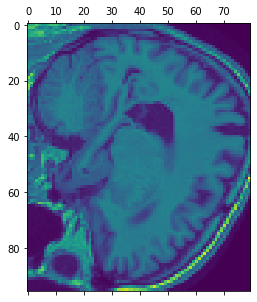

In [10]:
plt.matshow(template_data[0][28])
plt.show()

In [7]:
caps_info = pd.read_csv('/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv', sep='\t', 
                        error_bad_lines=False)[['participant_id', 'session_id', 'age', 'diagnosis', 'MMSE']].set_index(['participant_id','session_id'])

caps_info

/home/benoit.sautydechalon/anaconda3/envs/deformetrica/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (117,118,119,310) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


age diagnosis  MMSE
participant_id   session_id                      
sub-ADNI002S0295 ses-M00     84.8        CN  28.0
                 ses-M06     85.3        CN  28.0
                 ses-M12     85.8        CN  30.0
                 ses-M24     87.0        CN  29.0
                 ses-M36     87.8        CN  28.0
...                           ...       ...   ...
sub-ADNI941S6581 ses-M00     74.4        CN  30.0
                 ses-M12     75.4       NaN   NaN
                 ses-M24     76.4       NaN  30.0
sub-ADNI941S6803 ses-M00     75.0       MCI  28.0
sub-ADNI941S6854 ses-M00     86.2        AD  30.0

[16319 rows x 3 columns]

In [25]:
# Get the actual IDs from ADNI

path_imaging_data = "/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/subjects/"

sub_lst = sorted(os.listdir(path_imaging_data))

RIDs = []

for sub in tqdm(sub_lst):  
    sub_id = sub[12:]
    sub_path = path_imaging_data+sub
    ses_lst = sorted(os.listdir(sub_path))
    if caps_info.loc[sub]['MMSE'].between(10, 25).any():
        for ses in ses_lst:
            RIDs.append(int(sub_id))

RIDs = RIDs[:2691] + RIDs[2693:]
RIDs

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2254/2254 [00:08<00:00, 267.67it/s]


[295,
 295,
 295,
 295,
 295,
 295,
 295,
 295,
 619,
 619,
 619,
 619,
 685,
 685,
 685,
 685,
 685,
 685,
 685,
 685,
 729,
 729,
 729,
 729,
 729,
 729,
 729,
 729,
 729,
 729,
 816,
 816,
 816,
 938,
 938,
 938,
 938,
 954,
 954,
 954,
 954,
 955,
 955,
 1070,
 1070,
 1070,
 1070,
 1070,
 1070,
 1268,
 1268,
 1268,
 1268,
 1268,
 1268,
 1268,
 1268,
 4171,
 4171,
 4171,
 4171,
 4225,
 4225,
 4225,
 4225,
 4225,
 4225,
 4262,
 4262,
 4262,
 4262,
 4262,
 4262,
 4262,
 4521,
 4521,
 4521,
 4521,
 4521,
 4521,
 4521,
 4746,
 4746,
 4746,
 4746,
 5018,
 5018,
 5018,
 5018,
 6695,
 1021,
 1021,
 1057,
 1057,
 1057,
 1057,
 1057,
 1057,
 1057,
 1059,
 1059,
 1059,
 1059,
 1074,
 1074,
 1074,
 1074,
 1074,
 1074,
 1074,
 1074,
 1074,
 1122,
 1122,
 1122,
 1122,
 1122,
 1122,
 1122,
 1122,
 1122,
 1122,
 1122,
 1122,
 1122,
 1257,
 1257,
 2374,
 2374,
 2374,
 2374,
 4136,
 4136,
 4136,
 4136,
 4152,
 4152,
 4354,
 4354,
 4354,
 4354,
 4354,
 4354,
 4354,
 4354,
 4373,
 4373,
 4373,
 4892,


In [8]:
caps_info['ID'] = [int(sub[-4:]) for sub in caps_info.index.get_level_values(0)]
caps_info = caps_info.set_index('ID')
caps_info = caps_info.rename(columns={'age':'TIME','diagnosis':'diag'})
caps_info

,TIME,diag,MMSE
ID,,,
295,84.8,CN,28.0
295,85.3,CN,28.0
295,85.8,CN,30.0
295,87.0,CN,29.0
295,87.8,CN,28.0
...,...,...,...
6581,74.4,CN,30.0
6581,75.4,NaN,NaN
6581,76.4,NaN,30.0


In [25]:
RIDs = [int(sub) for sub in list(data['RID'])]

df = pd.DataFrame(index=RIDs)
df.index.name = 'ID'
df['labels'] = data['labels']
df['TIME'] = data['timepoints']
df['img_idx'] = np.arange(len(df))

In [26]:
df = df.merge(caps_info, on=['ID','TIME'])
df

,labels,TIME,img_idx,diag,MMSE
ID,,,,,
295,0,84.8,0,CN,28.0
295,0,85.3,1,CN,28.0
295,0,85.8,2,CN,30.0
295,0,87.0,3,CN,29.0
295,0,87.8,4,CN,28.0
...,...,...,...,...,...
6575,2246,74.5,10042,CN,28.0
6580,2247,79.9,10043,CN,27.0
6580,2247,80.9,10044,CN,29.0


## Load the models

In [27]:
sys.path.append('/home/benoit.sautydechalon/deformetrica')
from deformetrica.core.model_tools.neural_networks.networks import CVAE_3D, ACVAE_3D, VAE_GAN
from deformetrica.support.utilities.general_settings import Settings

import deformetrica as dfca
from deformetrica.core.models import LongitudinalAutoEncoder
from deformetrica.LAE_experiments.fit_longitudinal_auto_encoder import *
from deformetrica.support.utilities.general_settings import Settings

In [29]:
path_CAE = 'output_CVAE/CVAE_longitudinal'
path_model = 'model.xml'
path_data = 'ADNI_full_no_nan'

xml_parameters = dfca.io.XmlParameters()
xml_parameters._read_model_xml(path_model)
Settings().dimension = 256
Settings().number_of_sources = 4
Settings().device = device
deformetrica = dfca.Deformetrica(output_dir='output', verbosity=logger.level)

Logger has been set to: NOTSET
Deformetrica.__del__()


In [ ]:
torch_data = torch.load(path_data)
image_data = Dataset(torch_data['data'].unsqueeze(1).float(), torch_data['labels'], torch_data['timepoints'])
number_of_subjects = len(np.unique(image_data.labels))

model, dataset, individual_RER = instantiate_longitudinal_auto_encoder_model(logger, path_data, path_CAE=path_CAE,
                                                                    number_of_subjects=number_of_subjects, xml_parameters=xml_parameters)

In [ ]:
v0, p0, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(dataset.times, log_accelerations, onset_ages)

absolute_times_to_write = []

for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, modulation_matrix)

In [ ]:
model.CAE.VAE.to(device)
_, _, reconstructed = model.CAE.VAE(torch.FloatTensor(template_data.unsqueeze(0)).to(device))
reconstructed = reconstructed.cpu().detach().numpy()[0]

fig, axes = plt.subplots(3,10, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.02, hspace=0.02)

for i in range(10):
    axes[2][i].matshow(reconstructed[0][:,:,20 + 5*i])
    axes[1][i].matshow(reconstructed[0][:,20 + 5*i])
    axes[0][i].matshow(np.rot90(reconstructed[0][20 + 5*i]))

for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

#plt.matshow(template_data[0][:,:,40])
plt.show()

In [ ]:
ip = pd.DataFrame(index=df.index.unique() ,columns=['onset_age','log_acceleration','s1','s2','s3','s4'])

ip['onset_age'] = individual_RER['onset_age']
ip['log_acceleration'] = individual_RER['log_acceleration']
ip['s1'] = individual_RER['sources'][:,0]
ip['s2'] = individual_RER['sources'][:,1]
ip['s3'] = individual_RER['sources'][:,2]
ip['s4'] = individual_RER['sources'][:,3]

In [ ]:
ip

## Visual QC for reconstruction

In [104]:
template_data = data['data'][66].unsqueeze(0)

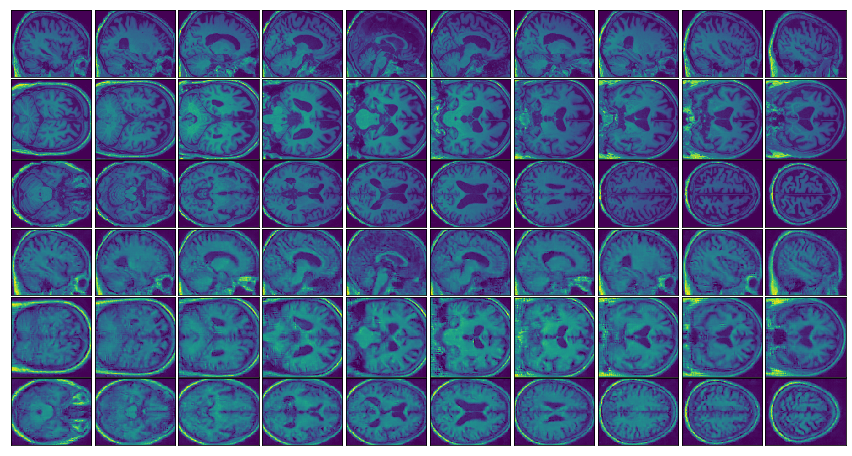

In [105]:
model.CAE.to(device)
_, _, reconstructed = model.CAE.VAE(torch.FloatTensor(template_data.unsqueeze(0)).to(device))
reconstructed = reconstructed.cpu().detach().numpy()[0]

fig, axes = plt.subplots(6,10, figsize=(15,8), gridspec_kw={'height_ratios':[.8,.96,.8,.8,.96,.8]})
plt.subplots_adjust(wspace=0.02, hspace=0.02)

for i in range(10):
    axes[0][i].matshow(np.rot90(template_data[0][20 + 5*i]))
    axes[1][i].matshow(template_data[0][:,20 + 5*i])
    axes[2][i].matshow(template_data[0][:,:,20 + 5*i])
    axes[3][i].matshow(np.rot90(reconstructed[0][20 + 5*i]))
    axes[4][i].matshow(reconstructed[0][:,20 + 5*i])
    axes[5][i].matshow(reconstructed[0][:,:,20 + 5*i])
    
for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

#plt.matshow(template_data[0][:,:,40])
plt.show()

## Gradient visualization

In [290]:
encoded_gradient = torch.zeros(Settings().number_of_sources+1, Settings().dimension)

source = torch.zeros(Settings().number_of_sources)  
t0 = model.get_reference_time()
encoded_gradient[0] = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([t0+2]).to(Settings().device),\
                                                                                sources=torch.FloatTensor(source).to(Settings().device))

for i in range(Settings().number_of_sources):
    source = torch.zeros(Settings().number_of_sources)  
    source[i] =  1/4
    encoded_gradient[i+1] = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([t0]).to(Settings().device),\
                                                                            sources=torch.FloatTensor(source).to(Settings().device))

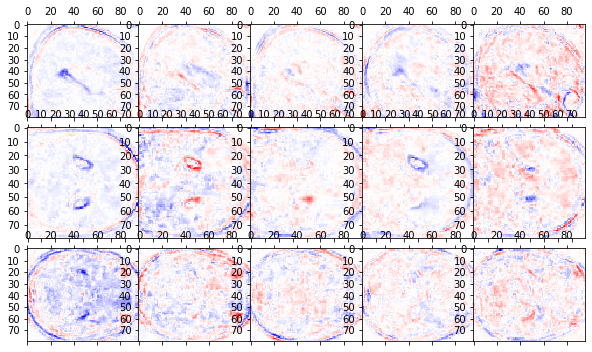

In [263]:
ncolumns = encoded_gradient.shape[0] 
fig, axes = plt.subplots(3, ncolumns, figsize=(2*ncolumns,6), gridspec_kw={'height_ratios':[.8,.96,.8]})
decoded_p0 = model.CAE.VAE.decoder(torch.zeros(encoded_gradient[0].shape).unsqueeze(0).to(device))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(0,ncolumns):
    simulated_img = model.CAE.VAE.decoder(encoded_gradient[i].unsqueeze(0).to(device)) - decoded_p0
    axes[0][i].matshow(np.rot90(simulated_img[0][0][58].cpu().detach().numpy()), cmap=matplotlib.cm.get_cmap('bwr'), norm=matplotlib.colors.CenteredNorm())
    axes[1][i].matshow(simulated_img[0][0][:,30].cpu().detach().numpy(), cmap=matplotlib.cm.get_cmap('bwr'), norm=matplotlib.colors.CenteredNorm())
    axes[2][i].matshow(simulated_img[0][0][:,:,25].cpu().detach().numpy(), cmap=matplotlib.cm.get_cmap('bwr'), norm=matplotlib.colors.CenteredNorm())
#for axe in axes:
 #   for ax in axe:
  #      ax.set_xticks([])
   #     ax.set_yticks([])

# Only plot the time dimension

In [291]:
encoded_gradient[0] = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([t0+2]).to(Settings().device),\
                                                                                sources=torch.FloatTensor(source).to(Settings().device))
decoded_p0 = model.CAE.VAE.decoder(torch.zeros(encoded_gradient[0].shape).unsqueeze(0).to(device))
simulated_img = model.CAE.VAE.decoder(encoded_gradient[0].unsqueeze(0).to(device)) - decoded_p0

In [292]:
x_slices = [8, 14, 23, 26, 32, 41, 48, 52, 58, 62, 68]

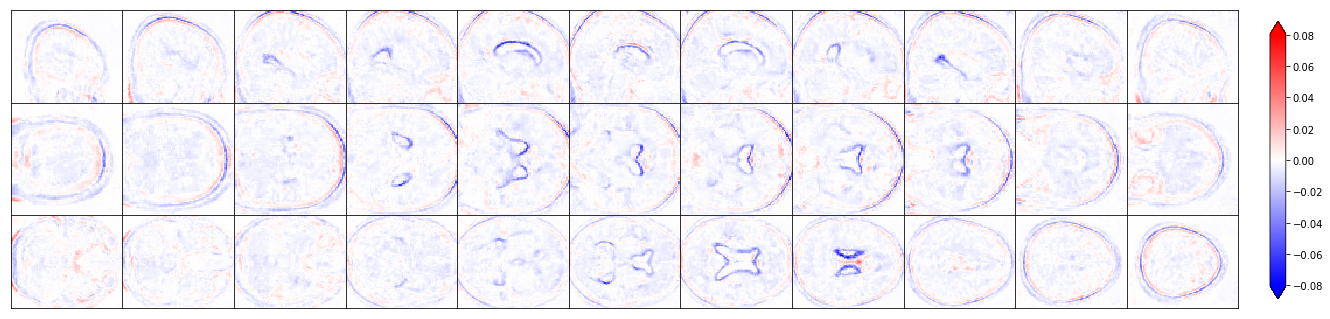

In [293]:
ncolumns = 11
fig, axes = plt.subplots(3, ncolumns, figsize=(2*ncolumns,5.5), gridspec_kw={'height_ratios':[.8,.96,.8]})
plt.subplots_adjust(wspace=0, hspace=0)

vmin, vmax = simulated_img.cpu().detach().numpy().min(), simulated_img.cpu().detach().numpy().max()
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=-vmin)

for i in range(0,ncolumns):
    im1 = axes[0][i].matshow(np.rot90(simulated_img[0][0][x_slices[i]].cpu().detach().numpy()), cmap=matplotlib.cm.get_cmap('bwr'), norm=norm)
    im2 = axes[1][i].matshow(simulated_img[0][0][:,10+7*i].cpu().detach().numpy(), cmap=matplotlib.cm.get_cmap('bwr'), norm=norm)
    im3 = axes[2][i].matshow(simulated_img[0][0][:,:,8+6*i].cpu().detach().numpy(), cmap=matplotlib.cm.get_cmap('bwr'), norm=norm)
    
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(mappable=im1, cax=cbar_ax, extend='both')

for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
encoded_gradient[0] = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([t0+4]).to(Settings().device),\
                                                                                sources=torch.FloatTensor(source).to(Settings().device))
p = model.spatiotemporal_reference_frame.get_position(torch.FloatTensor([t0+2]).to(Settings().device),\
                                                                                sources=torch.FloatTensor(source).to(Settings().device))
decoded_p0 = model.CAE.VAE.decoder(p)
simulated_img = model.CAE.VAE.decoder(encoded_gradient[0].unsqueeze(0).to(device)) - decoded_p0

In [292]:
x_slices = [8, 14, 23, 26, 32, 41, 48, 52, 58, 62, 68]

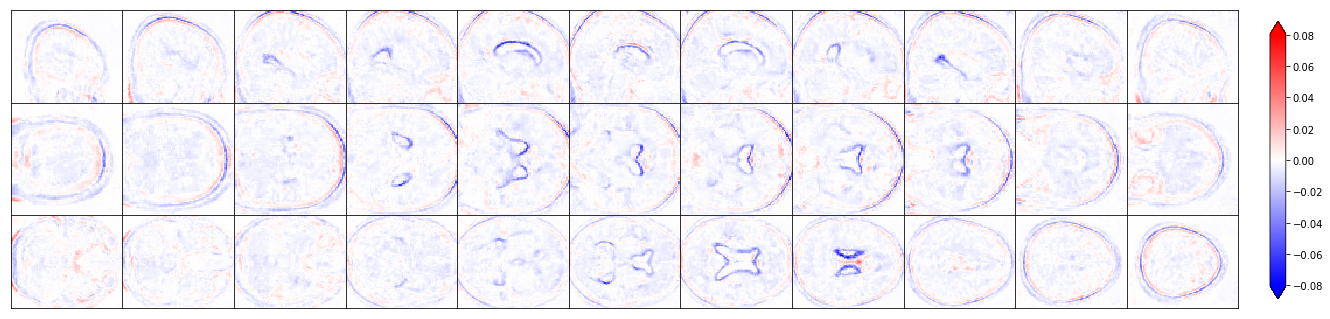

In [293]:
ncolumns = 11
fig, axes = plt.subplots(3, ncolumns, figsize=(2*ncolumns,5.5), gridspec_kw={'height_ratios':[.8,.96,.8]})
plt.subplots_adjust(wspace=0, hspace=0)

vmin, vmax = simulated_img.cpu().detach().numpy().min(), simulated_img.cpu().detach().numpy().max()
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=-vmin)

for i in range(0,ncolumns):
    im1 = axes[0][i].matshow(np.rot90(simulated_img[0][0][x_slices[i]].cpu().detach().numpy()), cmap=matplotlib.cm.get_cmap('bwr'), norm=norm)
    im2 = axes[1][i].matshow(simulated_img[0][0][:,10+7*i].cpu().detach().numpy(), cmap=matplotlib.cm.get_cmap('bwr'), norm=norm)
    im3 = axes[2][i].matshow(simulated_img[0][0][:,:,8+6*i].cpu().detach().numpy(), cmap=matplotlib.cm.get_cmap('bwr'), norm=norm)
    
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(mappable=im1, cax=cbar_ax, extend='both')

for axe in axes:
    for ax in axe:
        ax.set_xticks([])
        ax.set_yticks([])

In [252]:
[8+6*i for i in range(11)]

[8, 14, 20, 26, 32, 38, 44, 50, 56, 62, 68]

## Visualization tools for individual parameters

In [109]:
diag = pd.read_csv('~/ADNI-analysis/longitudinal_study/data/ADNI_cog_full.csv',usecols=['ID', 'session_id', 'TIME', 'diagnosis']).set_index('ID')

In [110]:
sub_diag = pd.DataFrame(index=diag.index.unique(), columns=['diag', 'label'])

for sub in sub_diag.index:
    if type(diag.loc[sub]) == pd.core.series.Series:
        sub_diag.drop(sub)
    else:
        if 'AD' in diag.loc[sub].values:
            sub_diag.loc[sub]['diag'] = 'AD'
            sub_diag.loc[sub]['label'] = 2
        elif 'MCI' in diag.loc[sub].values:
            sub_diag.loc[sub]['diag'] = 'MCI'
            sub_diag.loc[sub]['label'] = 1
        else:
            sub_diag.loc[sub]['diag'] = 'CN'
            sub_diag.loc[sub]['label'] = 0


In [115]:
ip = ip.merge(sub_diag, on='ID')
ip

,onset_age,log_acceleration,s1,s2,s3,s4,diag,label
ID,,,,,,,,
295,73.662916,-0.261200,-1.295171,-1.891490,3.182702,-1.589687,CN,0
619,69.572713,0.173954,-0.320836,-1.524325,-0.051515,-0.497309,AD,2
685,86.529182,-0.049367,-0.118236,-0.411714,0.805404,-0.792302,CN,0
729,74.846222,0.312988,-1.216061,0.785930,0.352869,-0.063889,AD,2
816,65.532162,-0.131537,0.056046,-1.146108,-0.006315,0.115379,AD,2
...,...,...,...,...,...,...,...,...
4365,71.229334,-0.574012,2.484361,-4.051259,-0.144640,1.029322,MCI,1
5124,76.139925,-1.225274,0.180888,-0.429493,0.215446,-0.491540,CN,0
6052,82.019465,0.043082,0.362831,0.086933,0.179770,-0.422042,MCI,1


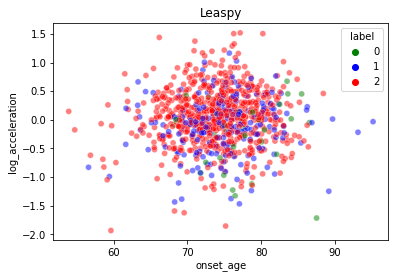

In [116]:
import seaborn as sns

sns.scatterplot(data = ip,
                x = 'onset_age', 
                y = 'log_acceleration', 
                hue = 'label',
                alpha=0.5, 
                palette = ['g', 'b', 'r'])
plt.title('Leaspy')
plt.show()

In [123]:
ip[['onset_age','log_acceleration','s1','s2','s3','s4']]

,onset_age,log_acceleration,s1,s2,s3,s4
ID,,,,,,
295,73.662916,-0.261200,-1.295171,-1.891490,3.182702,-1.589687
619,69.572713,0.173954,-0.320836,-1.524325,-0.051515,-0.497309
685,86.529182,-0.049367,-0.118236,-0.411714,0.805404,-0.792302
729,74.846222,0.312988,-1.216061,0.785930,0.352869,-0.063889
816,65.532162,-0.131537,0.056046,-1.146108,-0.006315,0.115379
...,...,...,...,...,...,...
4365,71.229334,-0.574012,2.484361,-4.051259,-0.144640,1.029322
5124,76.139925,-1.225274,0.180888,-0.429493,0.215446,-0.491540
6052,82.019465,0.043082,0.362831,0.086933,0.179770,-0.422042


array([[<AxesSubplot:title={'center':'onset_age'}>,
        <AxesSubplot:title={'center':'log_acceleration'}>],
       [<AxesSubplot:title={'center':'s1'}>,
        <AxesSubplot:title={'center':'s2'}>],
       [<AxesSubplot:title={'center':'s3'}>,
        <AxesSubplot:title={'center':'s4'}>]], dtype=object)

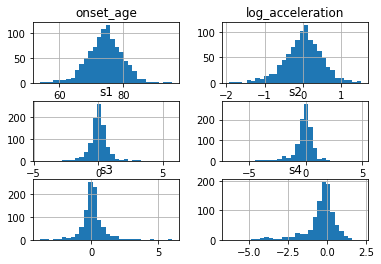

In [118]:
ip.hist(bins=30)

<AxesSubplot:>

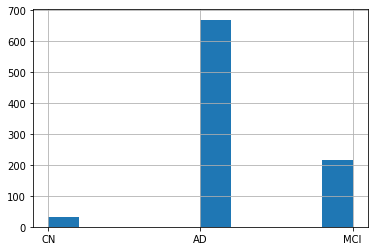

In [121]:
ip['diag'].hist()

/home/benoit.sautydechalon/anaconda3/envs/deformetrica/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

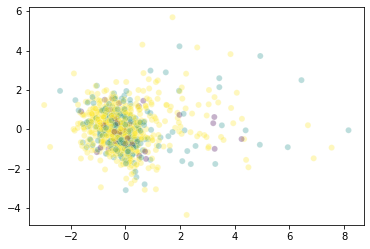

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

X = ip[['onset_age','log_acceleration','s1','s2','s3','s4']]
X = (X-X.mean())/X.std()
y = ip['label']

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

sns.scatterplot(X[:, 0], X[:, 1], c=y, alpha=.3)

## Plot the freesurfer volumes with reparametrized age

In [141]:
test = pd.read_csv('/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv', sep='\t', error_bad_lines=False)
t1-volume_group-adni2021_atlas-AAL2_ROI-Hippocampus_L_intensity
t1-volume_group-adni2021_atlas-AAL2_ROI-Hippocampus_R_intensity


In [145]:
for col in list(test.columns):
    if 'Ven' in col:
        print(col)

t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Third-Ventricle_intensity
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Third-Ventricle_intensity
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Fourth-Ventricle_intensity
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Fourth-Ventricle_intensity
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Inferior-Lateral-Ventricle_intensity
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Inferior-Lateral-Ventricle_intensity
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Lateral-Ventricle_intensity
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Lateral-Ventricle_intensity
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Ventral-Ventricle_intensity
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Ventral-Ventricle_intensity
t1-volume_group-adni2021_atlas-Hammers_ROI-Left-Lateral-Temporal-Ventricle_intensity
t1-volume_group-adni2021_atl

## Statistical tests to link ip with covariates

## Tools for figures

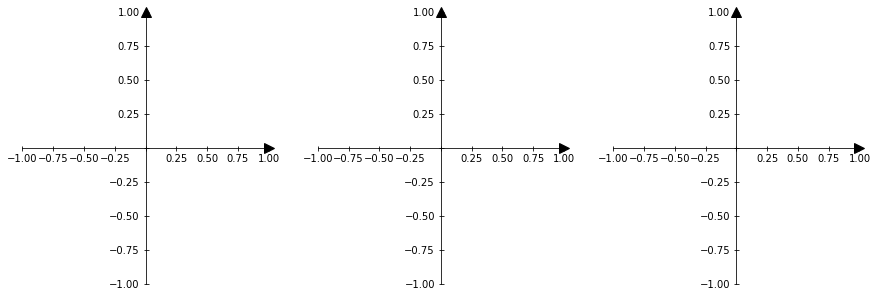

In [49]:
rc = {"xtick.direction" : "inout", "ytick.direction" : "inout",
      "xtick.major.size" : 5, "ytick.major.size" : 5,}
with plt.rc_context(rc):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    
    for i in range(3):
        ax[i].plot()

        ax[i].spines['left'].set_position('zero')
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_position('zero')
        ax[i].spines['top'].set_visible(False)
        ax[i].xaxis.set_ticks_position('bottom')
        ax[i].yaxis.set_ticks_position('left')

        # make arrows
        ax[i].plot((1), (0), ls="", marker=">", ms=10, color="k",
                transform=ax[i].get_yaxis_transform(), clip_on=False)
        ax[i].plot((0), (1), ls="", marker="^", ms=10, color="k",
                transform=ax[i].get_xaxis_transform(), clip_on=False)

        ax[i].yaxis.get_major_ticks()[4].label1.set_visible(False)
        ax[i].xaxis.get_major_ticks()[4].label1.set_visible(False)

        ax[i].set_xlim([-1, 1])
        ax[i].set_ylim([-1, 1])
    
    plt.show()

In [17]:
ax[i].yax[i]is.get_major_ticks()[1]

[]

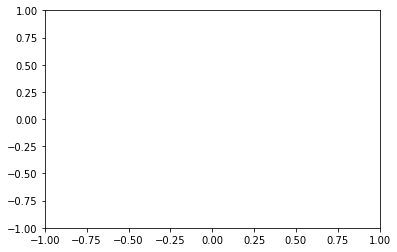

In [12]:
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.plot()

## Data-analysis on the encoded images

In [7]:
encoded = torch.load('../deformetrica/deformetrica/LAE_experiments/encoded_datasetCAE_300_epochs_5e-5_lr')

In [32]:
data = encoded['data']

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [28]:
data = scale(data)

In [27]:
data.mean()

tensor(0.5189)

In [33]:
covar_matrix = PCA(n_components = 20)

In [34]:
covar_matrix.fit(data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features


array([68.7, 72.7, 74.1, 75. , 75.6, 76.1, 76.6, 77. , 77.3, 77.6, 77.9,
       78.2, 78.5, 78.8, 79.1, 79.3, 79.5, 79.7, 79.9, 80.1])

## Data-analysis on the true images

In [26]:
data = torch.load('ADNI_small')

In [27]:
data = data['data']

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [33]:
data = (data-data.mean())/data.std()

In [34]:
covar_matrix = PCA(n_components = 20)

In [36]:
n_samples, nx, ny, nz = data.shape
data = data.reshape((n_samples, nx*ny*nz))

covar_matrix.fit(data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([13.5, 19.2, 22.9, 24.8, 26.6, 28.2, 29.7, 30.9, 32. , 33.1, 34.1,
       35. , 35.7, 36.4, 37.1, 37.8, 38.4, 39. , 39.5, 40. ])